In [27]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn import SKCompat
from tensorflow.contrib.learn import Estimator
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

In [28]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [29]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [31]:
# save the labels to a Pandas series target
target = train['label']
# Drop the label feature
train = train.drop(["label"], axis=1)
train = StandardScaler().fit_transform(np.float32(train))

In [32]:
image_size = train.shape[1]
print("image_size:{}".format(image_size))
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print("image_width: {}, image_height: {}".format(image_width, image_height))

image_size:784
image_width: 28, image_height: 28


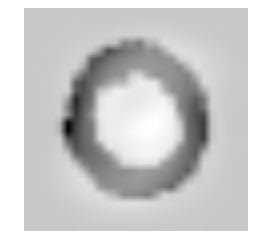

In [33]:
def display(img):
    show_img = img.reshape(image_width, image_height)
    plt.axis('off')
    plt.imshow(show_img, cmap=cm.binary)
    
display(train[1])

In [34]:
# labels_counts = target.unique().shape[0]

In [35]:
train_image = train[2000:]
train_labels = target[2000:]
validation_image = train[:2000]
validation_labels = target[:2000]

print("train_image shape:{}".format(train_image.shape))
print("validation_image shape:{}".format(validation_image.shape))

train_image shape:(40000, 784)
validation_image shape:(2000, 784)


In [36]:
def cnn_model_fn(features, labels, mode):
    # input layer
    input_layer = tf.reshape(features, [-1, 28, 28, 1])
    
    # Convolutional Layer 1
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5], padding='SAME', activation=tf.nn.relu)
    
    # Pooling Layer 1
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    # pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, padding='SAME')
    
    # Convolutional Layer 2
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], padding='SAME', activation=tf.nn.relu)
    
    # Pooling Layer 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7*7*64])
    
    # Dense Layer
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    # Add dropout to prevent overfitting
    # dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    dropout = tf.layers.dropout(inputs=dense, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    # Logists layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    loss = None
    train_op =None
    
    # Calculate Loss
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
        
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.0001,
            optimizer="Adam")
            # optimizer="SGD")
    
    # Generate Predictions
    predictions = {
      "classes": tf.argmax(
          input=logits, axis=1),
      "probabilities": tf.nn.softmax(
          logits, name="softmax_tensor")
    }
    
    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [37]:
mnist_classifier = SKCompat(Estimator(model_fn=cnn_model_fn))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11fbf85f8>, '_evaluation_master': '', '_task_type': None, '_master': '', '_is_chief': True, '_keep_checkpoint_max': 5, '_session_config': None, '_model_dir': '/var/folders/tk/hn2w33fj2314f_1dbprhk1l00000gn/T/tmpf1xd47f4', '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_environment': 'local', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}


In [37]:
mnist_classifier.fit(x=train_image, y=train_labels, batch_size=50, steps=20000)

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/tk/hn2w33fj2314f_1dbprhk1l00000gn/T/tmpf1xd47f4/model.ckpt.


INFO:tensorflow:step = 1, loss = 2.40651


INFO:tensorflow:global_step/sec: 9.32043


INFO:tensorflow:step = 101, loss = 0.480511 (10.730 sec)


INFO:tensorflow:global_step/sec: 8.22369


INFO:tensorflow:step = 201, loss = 0.295454 (12.160 sec)


KeyboardInterrupt: 

In [ ]:
metrics = {"accuracy": learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key='classes')}

In [ ]:
eval_result = mnist_classifier.score(x=validation_image, y=validation_labels, metrics=metrics)
print(eval_result)

INFO:tensorflow:Starting evaluation at 2017-06-27-02:49:16


INFO:tensorflow:Restoring parameters from /var/folders/tk/hn2w33fj2314f_1dbprhk1l00000gn/T/tmp8c9ws35x/model.ckpt-20000


INFO:tensorflow:Finished evaluation at 2017-06-27-02:49:17


INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9915, global_step = 20000, loss = 0.0308502


{'accuracy': 0.99150002, 'global_step': 20000, 'loss': 0.030850191}


In [ ]:
test_images = test.values
test_images = test_images.astype(np.float32)
test_images = StandardScaler().fit_transform(np.float32(test_images))
print("test_images.shape: {}".format(test_images.shape))
pred_result = mnist_classifier.predict(x=test_images, batch_size=50)
pred_result = pred_result['probabilities'].argmax(1)

test_images.shape: (28000, 784)


INFO:tensorflow:Restoring parameters from /var/folders/tk/hn2w33fj2314f_1dbprhk1l00000gn/T/tmp8c9ws35x/model.ckpt-20000


In [ ]:
np.savetxt('CNN_digit_recognizer.csv', 
           np.c_[range(1,len(test_images)+1),pred_result], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')